In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import psColor, bwLabel
import os

TRAIN_DIR = os.listdir(path='../data/treino')
DATA = [cv2.imread('../data/treino/' + image_path) for image_path in TRAIN_DIR]
TARGETS = [7, 5, 3, 4, 2, 4, 0, 3, 4, 4, 4, 1, 4, 3]

In [56]:
def showImages(imageArray, titles):
    for i, img in enumerate(imageArray):
        cv2.imshow(titles[i], img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# esta função vai dar print dos valores BGR ao contrario porque o MatPlotLib é normal e usa RGB, 
# cuidado para ele não trocar os valores e a imagem ficar estranha
def pltImages(imageArray, titles, cmap = None):
    n_images = len(imageArray)
    for i, image in enumerate(imageArray):
        plt.subplot(n_images, 1, i + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(titles[i])
        

In [57]:
#1. Leitura de imagens

image= DATA[8]

showImages([image], ["Imagem Original"])

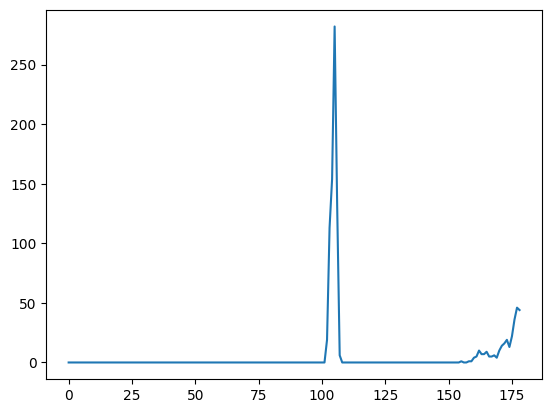

In [58]:
#2. Binarização 

def binarizacao (image, tolerance):
    """
    Função para realizar a binarização da imagem de modo a destacar os objetos presentes na mesma.

    Args:
        -image (np.array): Array da imagem em RGB que representa a imagem a ser binarização.
        -tolerance (int): Tolerância usada para calcular o range da componente Hue da cor de fundo da imagem. 

    Returns:
        -image_objects (np.array): Array da imagem RGB sem fundo.
        -bin_image (np.array): Array da imagem binarizada.
    
    """
    
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    #Obter a range de cores do fundo
    hist= cv2.calcHist(image_hsv, [0], None, [179], [0,179])
    plt.plot(hist)
    max_hue_idx= np.argmax(hist) #Obter o valor de hue que aparece mais na imagem
    low_hue= np.array([max_hue_idx - tolerance, 0, 0])
    high_hue= np.array([max_hue_idx + tolerance, 255, 255])
    
    #Tirar background da imagem através dos ranges de hue dados
    background_mask= cv2.inRange(image_hsv, low_hue, high_hue)
    inverted_mask= 255 - background_mask
    image_objects= cv2.bitwise_and(image, image, mask=inverted_mask)
    
    image_gs= cv2.cvtColor(image_objects, cv2.COLOR_BGR2GRAY)
    thresh, bin_image = cv2.threshold(image_gs, 0, 255, cv2.THRESH_OTSU)
    # bin_image= cv2.cvtColor(tresh_img, cv2.COLOR_GRAY2BGR)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    # mati... posso saber porque é que estás a transformar a imagem binarizada de novo para BGR aqui?
    # Isto fez o codigo lá de baixo dar erro porque obviamente que se estamos a trabalhar com uma imagem binarizada, 
    # ela não deve ter 3 canais de cor...
    # 
    # Troquei a variavel bin_image para o valor que realmente devia ser (a tua antiga tresh_image)

    return image_objects, bin_image

image_objects, bin_image= binarizacao(image, 20)
showImages([image_objects, bin_image], ["Imagem sem background", "Imagem Binarizada"])


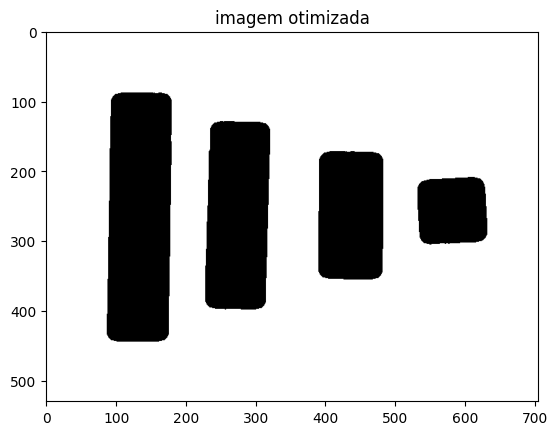

In [63]:
#3. melhoramento da imagem
def optimize_image(image):
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    image_opt = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    image_opt = cv2.morphologyEx(image_opt, cv2.MORPH_OPEN, kernel_open, iterations=2)
    return image_opt

image_opt = optimize_image(bin_image)
showImages([image_opt], ["Imagem apos melhoramento"])
pltImages([image_opt], ["imagem otimizada"], 'Greys')

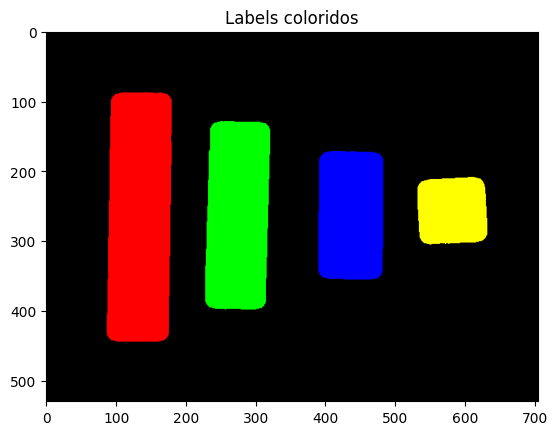

In [64]:
# Extração de componentes conexos

cc = cv2.connectedComponents(image_opt)

label_map = cc[1]

colored_image = np.zeros((image_opt.shape[0], image_opt.shape[1], 3), dtype=np.uint8)
colored_image[label_map == 1] = [255, 0, 0]
colored_image[label_map == 2] = [0, 255, 0]
colored_image[label_map == 3] = [0, 0, 255]
colored_image[label_map == 4] = [255, 255, 0]


showImages([colored_image], "contours")
pltImages([colored_image], ["Labels coloridos"])

In [ ]:
#Extração de de propriedades

# Mati já te devo ter dito mas ya não consigo continuar se não tiver esta parte tua feita,
# usa a variavel cc lá de cima, a colored image é só para efeitos de display